In [59]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.rcParams.update({'font.size': 14})

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config', 'nf:loaded']

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

clientside_dfs = {}
serverside_dfs = {}

In [60]:
target_features = ['ttfb', 'fcp', 'tti', 'lcp']

dirty_dfs =	{
  "CSR": pd.read_csv(f'../../../playwright/results/core-web-vitals/testrun-8/2024-12-16T09:36:50.835Z_results-csr.csv', sep=',').iloc[5:],
  "SSRH": pd.read_csv(f'../../../playwright/results/core-web-vitals/testrun-8/2024-12-15T22:05:17.080Z_results-ssrh.csv', sep=',').iloc[5:],
}

masks = {}

for name, df in dirty_dfs.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    clientside_dfs[name] = df[mask].copy()

In [61]:
dirty_df = pd.read_csv(f'../../../k6/results/csr/10000/metrics.csv', sep=',')

services = ["monolith", "cdn"]
dirty_df['total_cpu_percent'] = dirty_df[[f'{s}_cpu_percent' for s in services]].sum(axis=1)
dirty_df['total_mem_usage'] = dirty_df[[f'{s}_mem_usage' for s in services]].sum(axis=1)

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
serverside_dfs['CSR'] = dirty_df[mask].copy().reset_index(drop=True)

In [62]:
dirty_df = pd.read_csv(f'../../../k6/results/ssrh/10000/metrics.csv', sep=',')

services = ["monolith", "cdn", "discovery", "teasers", "recommendations"]
dirty_df['total_cpu_percent'] = dirty_df[[f'{s}_cpu_percent' for s in services]].sum(axis=1)
dirty_df['total_mem_usage'] = dirty_df[[f'{s}_mem_usage' for s in services]].sum(axis=1)

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
serverside_dfs['SSRH'] = dirty_df[mask].copy().reset_index(drop=True)

/var/folders/n3/c303nvyx3yv3x75n2g2xfh1h0000gn/T/ipykernel_7950/2537890424.py:58: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[4].set_ylim(0, max(percentiles.values()) * 1.2)
/var/folders/n3/c303nvyx3yv3x75n2g2xfh1h0000gn/T/ipykernel_7950/2537890424.py:61: RuntimeWarning: invalid value encountered in scalar divide
  percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100


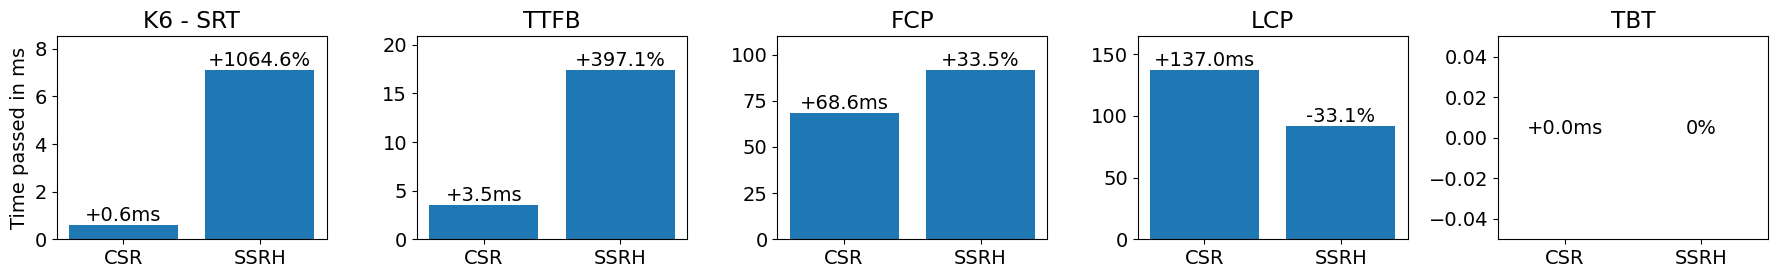

In [64]:
fig, axes = plt.subplots(ncols=5, figsize=(18, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

# Req response
percentiles = {d: serverside_dfs[d]['duration_mean'].mean() for d in serverside_dfs}
bars = axes[0].bar(percentiles.keys(), percentiles.values())
axes[0].set_ylim(0, max(percentiles.values()) * 1.2)

for i, bar in enumerate(bars):
    percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100
    label = f'{bar.get_height():+.1f}ms' if (i == 0) else f'{percentage:+.1f}%'
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(), label, ha='center', va='bottom')

axes[0].set_title('K6 - SRT')
axes[0].set_ylabel('Time passed in ms')

# TTFB
percentiles = {d: clientside_dfs[d]['ttfb'].quantile(0.75) for d in clientside_dfs}
bars = axes[1].bar(percentiles.keys(), percentiles.values())
axes[1].set_ylim(0, max(percentiles.values()) * 1.2)

for i, bar in enumerate(bars):
    percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100
    label = f'{bar.get_height():+.1f}ms' if (i == 0) else f'{percentage:+.1f}%'
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(), label, ha='center', va='bottom')

axes[1].set_title('TTFB')



# FCP
percentiles = {d: clientside_dfs[d]['fcp'].quantile(0.75) for d in clientside_dfs}
bars = axes[2].bar(percentiles.keys(), percentiles.values())
axes[2].set_ylim(0, max(percentiles.values()) * 1.2)

for i, bar in enumerate(bars):
    percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100
    label = f'{bar.get_height():+.1f}ms' if (i == 0) else f'{percentage:+.1f}%'
    axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height(), label, ha='center', va='bottom')

axes[2].set_title('FCP')

# LCP
percentiles = {d: clientside_dfs[d]['lcp'].quantile(0.75) for d in clientside_dfs}
bars = axes[3].bar(percentiles.keys(), percentiles.values())
axes[3].set_ylim(0, max(percentiles.values()) * 1.2)

for i, bar in enumerate(bars):
    percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100
    label = f'{bar.get_height():+.1f}ms' if (i == 0) else f'{percentage:+.1f}%'
    axes[3].text(bar.get_x() + bar.get_width()/2., bar.get_height(), label, ha='center', va='bottom')

axes[3].set_title('LCP')

# TBT
percentiles = {d: clientside_dfs[d]['tbt'].quantile(0.75) for d in clientside_dfs}
bars = axes[4].bar(percentiles.keys(), percentiles.values())
axes[4].set_ylim(0, max(percentiles.values()) * 1.2)

for i, bar in enumerate(bars):
    percentage = ((bar.get_height() / list(percentiles.values())[0]) - 1) * 100
    label = f'{bar.get_height():+.1f}ms' if (i == 0) else f'0%'
    axes[4].text(bar.get_x() + bar.get_width()/2., bar.get_height(), label, ha='center', va='bottom')

axes[4].set_title('TBT')

plt.tight_layout()
plt.show()